In [1]:
## Load tables
import pandas as pd
import numpy as np

demand = pd.read_csv('data/demanda.csv')
temp = pd.read_csv('data/temp.csv')

In [2]:
## Combine tables 

combined = pd.merge(temp, demand, how='left', left_on=['fecha', 'hora'], right_on =['fecha','hora'])
combined['fecha_hora'] = combined['fecha'] +" "+ combined['hora'].map(str)
del combined['fecha']
# del combinado['hora']
combined['fecha_hora'] = pd.to_datetime(combined['fecha_hora'] , format='%d/%m/%Y %H', errors='coerce')

In [3]:
# Calulate working days

combined['laborable'] = combined.apply(lambda row: 0 if row['fecha_hora'].weekday() in [5,6 ] else 1, axis=1)

In [6]:
combined

,hora,temperatura,demanda,fecha_hora,laborable,dem_sem_prev,dem_dia_prev
0,0,14.8,211.523,2013-06-01 00:00:00,0,0.000,0.000
1,1,14.4,192.062,2013-06-01 01:00:00,0,0.000,0.000
2,2,14.4,177.325,2013-06-01 02:00:00,0,0.000,0.000
3,3,14.1,178.419,2013-06-01 03:00:00,0,0.000,0.000
4,4,13.3,175.584,2013-06-01 04:00:00,0,0.000,0.000
...,...,...,...,...,...,...,...
18235,19,15.6,300.910,2015-06-30 19:00:00,1,354.369,299.486
18236,20,14.5,316.836,2015-06-30 20:00:00,1,367.602,314.036
18237,21,12.9,313.155,2015-06-30 21:00:00,1,371.286,311.694
18238,22,12.9,302.900,2015-06-30 22:00:00,1,365.233,296.013


In [4]:
# Colculate demand same day previous week 

combined['dem_sem_prev'] = combined.apply(lambda row: 
                    0 if combined.loc[combined['fecha_hora'] == row['fecha_hora'] - timedelta(days=7)].empty 
                    else combined.loc[combined['fecha_hora'] == row['fecha_hora'] - timedelta(days=7)].iat[0,2]
         , axis=1)

In [5]:
#Calculate demand last 24 hours
from datetime import timedelta

def last_24h(dataset):
    dataset['dem_dia_prev'] = dataset.apply(lambda row: 
                        0 if dataset.loc[dataset['fecha_hora'] == row['fecha_hora'] - timedelta(days=1)].empty 
                        else dataset.loc[dataset['fecha_hora'] == row['fecha_hora'] - timedelta(days=1)].iat[0,2]
             , axis=1)
    
    return dataset
    
    
combined = last_24h(combined)

In [26]:
from math import floor
### Extract data from Argentina Fall on 2013
### And esplit the dataset in train test 

def train_test_data(dataset, factor=0.8):
    train_test_separador = floor(len(dataset)* factor) 
    train = dataset[:train_test_separador]
    test = dataset[train_test_separador:]
    return train, test

def between_dates(dataset, start, end):
    start = dataset['fecha_hora'] >= start
    end = dataset['fecha_hora'] <= end
    
    return dataset.loc[ start  & end ]

train, test = train_test_data(between_dates(combined, '2013-03-21 00:00:00', '2013-07-21 23:59:59'))


In [29]:
test

,hora,temperatura,demanda,fecha_hora,laborable,dem_sem_prev,dem_dia_prev
979,19,21.8,297.262,2013-07-11 19:00:00,1,302.520,296.400
980,20,21.0,288.921,2013-07-11 20:00:00,1,299.329,289.978
981,21,19.9,278.157,2013-07-11 21:00:00,1,292.885,278.556
982,22,19.2,261.288,2013-07-11 22:00:00,1,273.043,264.416
983,23,19.1,236.850,2013-07-11 23:00:00,1,245.437,239.587
...,...,...,...,...,...,...,...
1219,19,6.4,342.368,2013-07-21 19:00:00,0,272.962,324.513
1220,20,4.8,353.965,2013-07-21 20:00:00,0,272.070,329.020
1221,21,4.1,354.663,2013-07-21 21:00:00,0,266.678,327.977
1222,22,3.3,339.454,2013-07-21 22:00:00,0,254.349,313.499


In [31]:
import statsmodels.formula.api as smf

formula = 'demanda ~ temperatura + hora + laborable'
def fit_lm(data, formula):
    result = smf.ols(formula, data=data).fit()
    print(result.summary())
    return result

result =fit_lm(train,formula)

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     499.9
Date:                Tue, 31 Mar 2020   Prob (F-statistic):          1.22e-196
Time:                        19:49:52   Log-Likelihood:                -4542.9
No. Observations:                 979   AIC:                             9094.
Df Residuals:                     975   BIC:                             9113.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     197.8949      2.826     70.035      

In [32]:
results = pd.DataFrame(result.predict(exog=test), columns=['prediccion'])
results['real'] = test['demanda']
results['fecha_hora'] = test['fecha_hora']
results

,prediccion,real,fecha_hora
979,252.843348,297.262,2013-07-11 19:00:00
980,259.354745,288.921,2013-07-11 20:00:00
981,266.561777,278.157,2013-07-11 21:00:00
982,272.841296,261.288,2013-07-11 22:00:00
983,277.729547,236.850,2013-07-11 23:00:00
...,...,...,...
1219,271.525760,342.368,2013-07-21 19:00:00
1220,279.892183,353.965,2013-07-21 20:00:00
1221,286.171702,354.663,2013-07-21 21:00:00
1222,292.683100,339.454,2013-07-21 22:00:00


In [33]:
rest =( 1/len(results)) * sum(abs((results.real - results.prediccion)/ results.real))
f'{(rest * 100):.2f}%'

'9.26%'

<IPython.core.display.Javascript object>


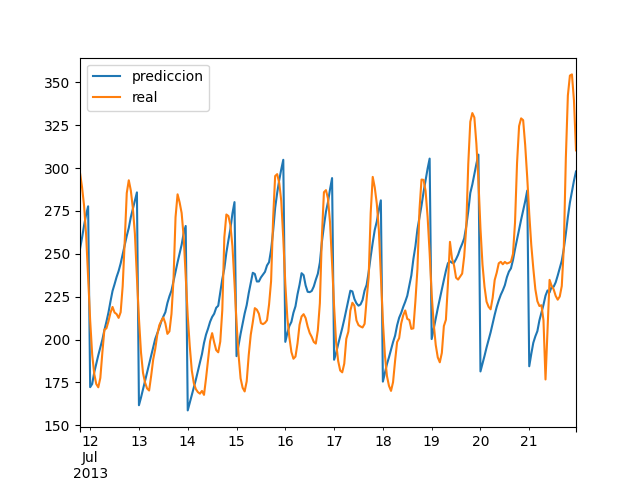

In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt
results.plot(x="fecha_hora")
plt.show()
